# Airbnb: cleaning fees

Data has been downloaded from: http://insideairbnb.com/get-the-data.html. The first step is to read the data and merge the two cities.  

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

df = pd.read_csv("data/listings_amsterdam.csv", index_col="id", low_memory=False)

We have over 20 thousand listings in Amsterdam.

Let start with having a look at the cleaning fees and the price per night. 

In [220]:
df[["price","cleaning_fee"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 2818 to 40655209
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         20025 non-null  object
 1   cleaning_fee  16421 non-null  object
dtypes: object(2)
memory usage: 469.3+ KB


It seems that price has no missing values, while the cleaning fee has over 6 thousand missing values. After checkig a few of the ads on the website, I concluded that the missing values can be interpreted as not charging a cleaning fee so they can be recoded to 0. Also, we need to get rid of the dollar sign (should be Euro actually) and convert the columns to floats. Also, I am creating a 'cleaning ratio' which is the cleaning fee divided by the price per night.

In [221]:
for var in ['price','cleaning_fee']:

    df[var] = df[var].replace({'\$':''}, regex=True)
    df[var] = df[var].replace({'\,':''}, regex=True).astype(float)

df['cleaning_fee'].fillna(0, inplace=True) 

df['cleaning_ratio'] = df.cleaning_fee / df.price


Lets see if the data have some outliers or other strange values.

In [222]:
df[['price','cleaning_fee','cleaning_ratio']].describe(percentiles=[.25,.5,.75,.9,.95,.99])

price  cleaning_fee  cleaning_ratio
count  20025.000000  20025.000000    2.002500e+04
mean     163.251685     32.358652             inf
std      198.538156     27.821606             NaN
min        0.000000      0.000000    0.000000e+00
25%       99.000000     10.000000    8.823529e-02
50%      130.000000     30.000000    2.250000e-01
75%      185.000000     50.000000    3.333333e-01
90%      255.000000     60.000000    4.500000e-01
95%      345.000000     75.000000    5.333333e-01
99%      600.000000    120.000000    7.575758e-01
max     9000.000000    531.000000             inf

Seems like some of the listings have a price of 0 and some also have a quite extreme prices. Lets look more closely.

In [223]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='price').tail(8)

price  cleaning_fee  cleaning_ratio
id                                            
19686192  5000.0           0.0        0.000000
29926643  5040.0          50.0        0.009921
33842636  7550.0           0.0        0.000000
258273    8000.0          15.0        0.001875
6655554   8915.0         500.0        0.056085
286500    9000.0           0.0        0.000000
290701    9000.0           0.0        0.000000
33730638  9000.0           0.0        0.000000

9000 per night is high, but not unusual so lets keep that data.

In [224]:
df = df.loc[df.price != 0]

In [225]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='cleaning_fee').tail()

price  cleaning_fee  cleaning_ratio
id                                            
5974980    118.0         480.0        4.067797
6655554   8915.0         500.0        0.056085
10328570   380.0         500.0        1.315789
2234543    600.0         500.0        0.833333
6149173    100.0         531.0        5.310000

Some cleaning fees look rather high and in some cases much higher than the price for one night. Most extreme is a 1000 Euro cleaning fee, but this is also for a listing with a price of 3900 per night so its realistic.

Next up some distribtional plots of the price and cleaning fee in each city. Because of the skewness in the distribution I transform the variables to a log scale. Note that this excludes the listings that do not charge a cleaning fee.

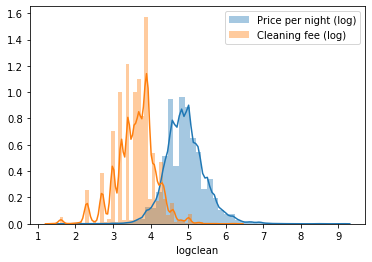

In [226]:
df['logprice'] = np.log(df.price)
df['logclean'] = np.log(df.cleaning_fee[df.cleaning_fee > 0])
sns.distplot(df['logprice'], label="Price per night (log)")
sns.distplot(df['logclean'].dropna(), label="Cleaning fee (log)")
plt.legend()
plt.show()

The plots above shows is some large peaks in the cleaning fees which shows that certain levels of fees are used more commonly.

Do more expensive places to stay come with higher cleaning fees? The plots below seem to suggest this is the case, though there is still a considerable amount of variation. 

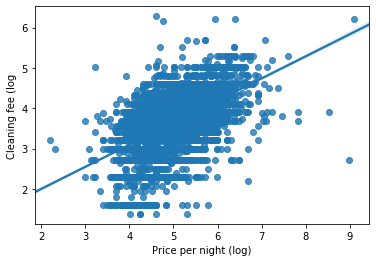

In [227]:
sns.regplot(x='logprice', y='logclean', data=df)
plt.xlabel('Price per night (log)')
plt.ylabel('Cleaning fee (log')
plt.show()

In [228]:
df.logprice.describe()

count    20024.000000
mean         4.922225
std          0.531930
min          1.609438
25%          4.595120
50%          4.867534
75%          5.220356
max          9.104980
Name: logprice, dtype: float64

In [229]:
import folium
from folium.plugins import HeatMap

hmap = folium.Map(location=[52.35, 4.893699], zoom_start=13,)

hm_price = HeatMap( list(zip(df.latitude, df.longitude, df.logprice)),
                   min_opacity=0.1,
                   max_val=10,
                   radius=4, blur=6,
                   max_zoom=13,
                 )

hmap.add_child(hm_price)
hmap


In [230]:
hmap = folium.Map(location=[52.35, 4.893699], zoom_start=13,)

mapdata = df[['longitude','latitude','logclean']].dropna()

hm_clean = HeatMap( list(zip(mapdata.latitude, mapdata.longitude, mapdata.logclean)),
                   min_opacity=0.1,
                   max_val=6,
                   radius=4, blur=6,
                   max_zoom=13,
                 )

hmap.add_child(hm_clean)
hmap


In [231]:
mapdata.logclean.describe()

count    15344.000000
mean         3.610639
std          0.524586
min          1.386294
25%          3.367296
50%          3.688879
75%          3.912023
max          6.274762
Name: logclean, dtype: float64